# EDA - Imbalanced Classes Strategies - AutoML implementation

As EDA will show, the positive results to Covid-19 are a Imbalanced label. Just 10.9% patients tested was positive.

In this notebook i will:
- Predict Covid-19
- Test 3 strategies to solve the imbalannced class
- Implement a AutoML to get a faster result

Next Implementations:
- Test Deep learning in AutoML
- Implement the suggestions given from community

You can see the AutoML results in my github: https://github.com/Angelo-Baruffi/Diagnosis-of-COVID-19/blob/master/Analysis.ipynb

In [1]:
import pandas as pd
import numpy as np
from IPython.display import HTML, display
import tabulate
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [22]:
#UTILS

def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum())/df.isnull().count().sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)

def zeros_data(df):
    #Processes zeros values
    total = (df == 0).sum().sort_values(ascending=False)
    percent = ((df == 0).sum())/(df == 0).count().sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)

def print_table(df):
    display(HTML(tabulate.tabulate(df, tablefmt='html')))
    
def predict_autoH2o(df_predict,  y_column, exclude_algos = [], max_runtime_secs=60*60, nfold=0, sort_metric='aucpr'):
    
    df_h2o = h2o.H2OFrame(df_predict)
    df_h2o = df_h2o[1:,:]
    train,test = df_h2o.split_frame(ratios=[.7], seed = 1)
    
    x = train.columns
    y = y_column
    x.remove(y)
    
    plt.title('Train')
    train.as_data_frame()[y].value_counts().plot(kind='bar', legend = True)
    plt.figure()
    plt.title('Test')
    test.as_data_frame()[y].value_counts().plot(kind='bar', legend = True)

    aml, leaders = predict_autoH2oTrainTest(train, train,  y, x,exclude_algos = exclude_algos, max_runtime_secs=max_runtime_secs, nfold=nfold, sort_metric=sort_metric)
    
    return aml, leaders

def predict_autoH2oTrainTest(train, test,  y, x, exclude_algos = [], max_runtime_secs=60*60, nfold=0, sort_metric='aucpr'):
    # For binary classification, response should be a factor
    train[y] = train[y].asfactor()
    test[y] = test[y].asfactor()

    # Run AutoML for 20 base models (limited to 1 hour max runtime by default)
    exclude_algos = exclude_algos

    aml = H2OAutoML(max_runtime_secs=max_runtime_secs, seed=1, exclude_algos = exclude_algos, nfolds = nfold, sort_metric=sort_metric)
    aml.train(x=x, y=y, training_frame=train, validation_frame=test)

    # AutoML Leaderboard
    lb = aml.leaderboard

    # Optionally edd extra model information to the leaderboard
    lb = get_leaderboard(aml, extra_columns='ALL')

    # Print all rows (instead of default 10 rows)
    return aml, lb.head(rows=lb.nrows)

In [3]:
df = pd.read_excel('dataset.xlsx')

In [4]:
df.columns

Index(['Patient ID', 'Patient age quantile', 'SARS-Cov-2 exam result',
       'Patient addmited to regular ward (1=yes, 0=no)',
       'Patient addmited to semi-intensive unit (1=yes, 0=no)',
       'Patient addmited to intensive care unit (1=yes, 0=no)', 'Hematocrit',
       'Hemoglobin', 'Platelets', 'Mean platelet volume ',
       ...
       'Hb saturation (arterial blood gases)',
       'pCO2 (arterial blood gas analysis)',
       'Base excess (arterial blood gas analysis)',
       'pH (arterial blood gas analysis)',
       'Total CO2 (arterial blood gas analysis)',
       'HCO3 (arterial blood gas analysis)',
       'pO2 (arterial blood gas analysis)', 'Arteiral Fio2', 'Phosphor',
       'ctO2 (arterial blood gas analysis)'],
      dtype='object', length=111)

Fields with null 105
Number of field in df 111


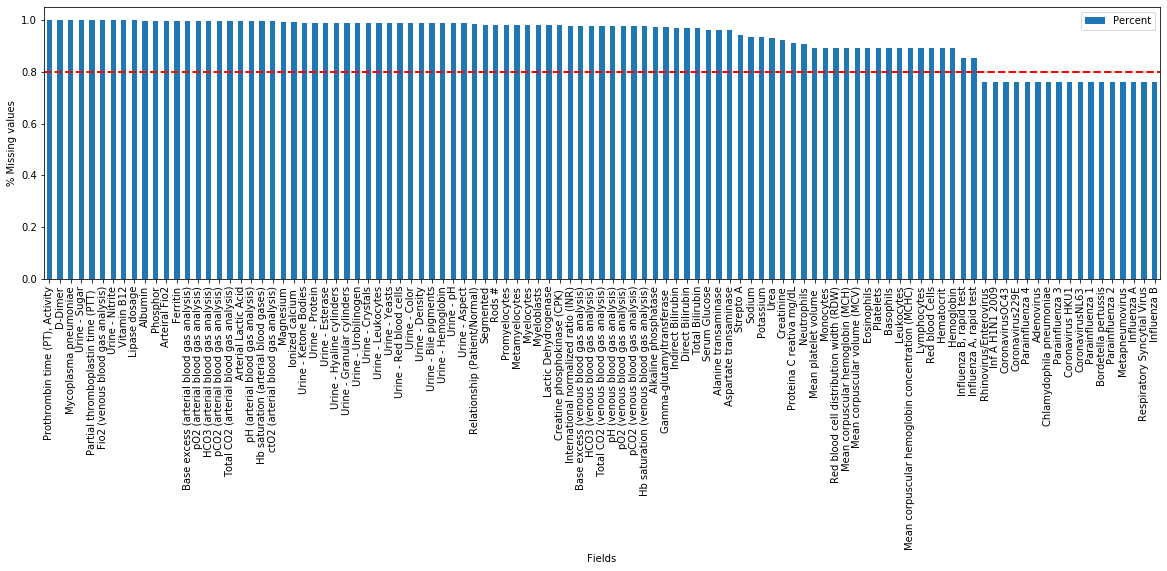

In [5]:
thr = 0.8

fig, ax = plt.subplots(figsize=(20, 5))
plt.xlabel('Fields')
plt.ylabel('% Missing values')
miss_df = missing_data(df)
miss_df = miss_df[miss_df['Percent'] != 0]
miss_df.drop('Total', axis=1).plot(kind='bar', ax=ax)
print('Fields with null {}'.format(miss_df.shape[0]))
print('Number of field in df {}'.format(df.shape[1]))
ax.axhline(y=thr, color='r', linestyle='--', lw=2)


In [6]:
miss_df_remove = miss_df[miss_df['Percent'] >= thr]

### Possible Assumption
To do this analysis, It's possible suppose that this nulls fields happened because they are tests did with already critical patients. With this assumption we can in future create a prediction model that can be used when the paciente arrive in the hospital

In [7]:
column_id = 'Patient ID'

#df_clean = df.drop(miss_df_remove.index, axis=1)
df_clean = df.drop(column_id, axis=1)

df_clean.columns

Index(['Patient age quantile', 'SARS-Cov-2 exam result',
       'Patient addmited to regular ward (1=yes, 0=no)',
       'Patient addmited to semi-intensive unit (1=yes, 0=no)',
       'Patient addmited to intensive care unit (1=yes, 0=no)', 'Hematocrit',
       'Hemoglobin', 'Platelets', 'Mean platelet volume ', 'Red blood Cells',
       ...
       'Hb saturation (arterial blood gases)',
       'pCO2 (arterial blood gas analysis)',
       'Base excess (arterial blood gas analysis)',
       'pH (arterial blood gas analysis)',
       'Total CO2 (arterial blood gas analysis)',
       'HCO3 (arterial blood gas analysis)',
       'pO2 (arterial blood gas analysis)', 'Arteiral Fio2', 'Phosphor',
       'ctO2 (arterial blood gas analysis)'],
      dtype='object', length=110)

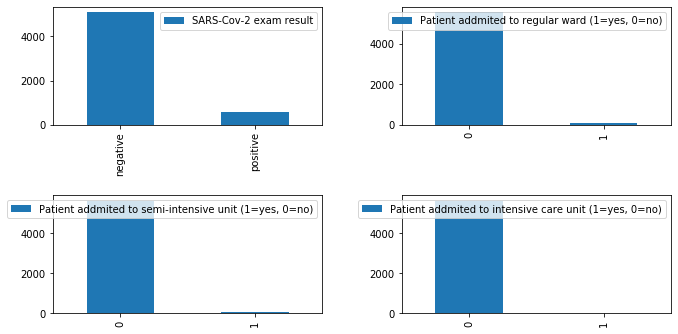

In [8]:
label_fields = ['SARS-Cov-2 exam result','Patient addmited to regular ward (1=yes, 0=no)',
       'Patient addmited to semi-intensive unit (1=yes, 0=no)',
       'Patient addmited to intensive care unit (1=yes, 0=no)']

fig, ax = plt.subplots(2,2,figsize=(10, 5))

for i,label_field in enumerate(label_fields):
    df[label_field].value_counts().plot(kind='bar', ax=ax.flatten()[i], legend = True)

fig.tight_layout(pad=2.0)

In [9]:
df[label_fields[0]].value_counts()

negative    5086
positive     558
Name: SARS-Cov-2 exam result, dtype: int64

In [10]:
df_clean.select_dtypes('O')

,SARS-Cov-2 exam result,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,...,Urine - Ketone Bodies,Urine - Nitrite,Urine - Urobilinogen,Urine - Protein,Urine - Leukocytes,Urine - Crystals,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color
0,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,negative,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,negative,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5640,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5641,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5642,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,absent,NaN,normal,absent,29000,Ausentes,absent,absent,absent,yellow


In [11]:
df_clean = df_clean.astype('float', errors='ignore')
for column in df_clean.select_dtypes('O').columns:
    
    print('Field: {}'.format(column))
    print('Values: {}'.format(set(df_clean[column])))
    print('---')
    

Field: SARS-Cov-2 exam result
Values: {'positive', 'negative'}
---
Field: Respiratory Syncytial Virus
Values: {nan, 'not_detected', 'detected'}
---
Field: Influenza A
Values: {nan, 'not_detected', 'detected'}
---
Field: Influenza B
Values: {nan, 'not_detected', 'detected'}
---
Field: Parainfluenza 1
Values: {nan, 'not_detected', 'detected'}
---
Field: CoronavirusNL63
Values: {nan, 'not_detected', 'detected'}
---
Field: Rhinovirus/Enterovirus
Values: {nan, 'detected', 'not_detected'}
---
Field: Coronavirus HKU1
Values: {nan, 'not_detected', 'detected'}
---
Field: Parainfluenza 3
Values: {nan, 'not_detected', 'detected'}
---
Field: Chlamydophila pneumoniae
Values: {nan, 'not_detected', 'detected'}
---
Field: Adenovirus
Values: {nan, 'not_detected', 'detected'}
---
Field: Parainfluenza 4
Values: {nan, 'not_detected', 'detected'}
---
Field: Coronavirus229E
Values: {nan, 'not_detected', 'detected'}
---
Field: CoronavirusOC43
Values: {nan, 'not_detected', 'detected'}
---
Field: Inf A H1N1 20

In [12]:
df_clean = df_clean.replace('negative', 0).replace('positive', 1)
df_clean = df_clean.replace('detected',1).replace('not_detected',0)
df_clean = df_clean.replace('present',1).replace('absent',0)
df_clean = df_clean.replace('not_done',np.nan).replace('Não Realizado',np.nan)
df_clean = df_clean.replace('normal',1)
df_clean = df_clean.replace('<1000',1000)
df_clean['Urine - pH'] = df_clean['Urine - pH'].astype('float')
df_clean['Urine - Leukocytes'] = df_clean['Urine - pH'].astype('float')

# H20 AutoML test

In [14]:
import h2o
from h2o.automl import H2OAutoML, get_leaderboard

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.231-b11, mixed mode)
  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ANGELO~1\AppData\Local\Temp\tmpiyjwnaxg
  JVM stdout: C:\Users\ANGELO~1\AppData\Local\Temp\tmpiyjwnaxg\h2o_Angelo_Baruffi_started_from_python.out
  JVM stderr: C:\Users\ANGELO~1\AppData\Local\Temp\tmpiyjwnaxg\h2o_Angelo_Baruffi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,-03:00
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.1.1
H2O cluster version age:,23 days
H2O cluster name:,H2O_from_python_Angelo_Baruffi_irnume
H2O cluster total nodes:,1
H2O cluster free memory:,1.747 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [ ]:
aml_normal, leaders_normal = predict_autoH2o(
    df_clean,
    label_fields[0],
    exclude_algos = [],
    max_runtime_secs=60*60,
    nfold=0,
    sort_metric='aucpr'
)
leaders_normal

In [16]:
leaders_normal

model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms
DeepLearning_grid__3_AutoML_20200329_034910_model_1,0.468762,0.573789,0.411019,0.421801,0.321373,0.103281,61860,2.31048
DeepLearning_grid__1_AutoML_20200329_034910_model_1,0.454521,0.603602,0.458067,0.408137,0.325836,0.106169,69922,0.406316
DeepLearning_grid__1_AutoML_20200329_034910_model_2,0.409845,0.563323,0.562055,0.437516,0.321315,0.103243,298644,4.8695
GLM_1_AutoML_20200329_034910,0.227208,0.65854,0.338553,0.366708,0.312595,0.0977158,59833,0.017706
DeepLearning_grid__2_AutoML_20200329_034910_model_3,0.208531,0.620963,0.579015,0.383789,0.322141,0.103775,504144,2.11621
GBM_grid__1_AutoML_20200329_034910_model_29,0.204963,0.646273,0.350646,0.362112,0.312416,0.0976039,242,0.012911
GBM_grid__1_AutoML_20200329_034910_model_11,0.199427,0.638416,0.354226,0.379255,0.319133,0.101846,509,0.027337
XRT_1_AutoML_20200329_034910,0.193452,0.659006,0.353799,0.375776,0.318758,0.101607,972,0.026544
DeepLearning_grid__3_AutoML_20200329_034910_model_3,0.18651,0.62295,0.68822,0.40118,0.326318,0.106484,457875,2.31458
GBM_grid__1_AutoML_20200329_034910_model_3,0.184498,0.619876,0.35744,0.370932,0.318513,0.10145,431,0.082566


In [17]:
aml_normal.leader

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid__3_AutoML_20200329_034910_model_1


Status of Neuron Layers: predicting SARS-Cov-2 exam result, 2-class classification, bernoulli distribution, CrossEntropy loss, 258.502 weights/biases, 3,2 MB, 846.801 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,5065,Input,15,,,,,,,,,
1,,2,50,RectifierDropout,20,0,0,0.543925,0.437231,0,0.000396447,0.0300736,0.408993,0.160886
2,,3,50,RectifierDropout,20,0,0,0.0400985,0.0548819,0,-0.0144649,0.171709,0.311912,0.454739
3,,4,50,RectifierDropout,20,0,0,0.0877939,0.154299,0,-0.0817379,0.15767,0.763407,0.101212
4,,5,2,Softmax,,0,0,0.0227538,0.0172158,0,-0.0562269,0.751416,0.00113671,1.2206




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.07233503204992123
RMSE: 0.26895172810361573
LogLoss: 0.2618582787052476
Mean Per-Class Error: 0.35046256641793216
AUC: 0.7053774933945008
AUCPR: 0.593912755047747
Gini: 0.4107549867890017

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1110461072439802: 


,,0,1,Error,Rate
0,0,3231.0,1.0,0.0003,(1.0/3232.0)
1,1,284.0,57.0,0.8328,(284.0/341.0)
2,Total,3515.0,58.0,0.0798,(285.0/3573.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,1.110461e-01,0.285714,38.0
1,max f2,7.464665e-02,0.428790,55.0
2,max f0point5,1.110461e-01,0.497382,38.0
3,max accuracy,1.110461e-01,0.920235,38.0
4,max precision,9.999998e-01,1.000000,0.0
5,max recall,1.684984e-03,1.000000,200.0
6,max specificity,9.999998e-01,1.000000,0.0
7,max absolute_mcc,1.110461e-01,0.387929,38.0
8,max min_per_class_accuracy,7.952422e-02,0.326733,39.0
9,max mean_per_class_accuracy,7.464665e-02,0.649537,55.0



Gains/Lift Table: Avg response rate:  9,54 %, avg score:  7,63 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010076,9.998935e-01,10.478006,10.478006,1.000000,0.999980,1.000000,0.999980,0.105572,0.105572,947.800587,947.800587
1,,2,0.700812,7.952422e-02,1.239699,1.372518,0.118314,0.086300,0.130990,0.099436,0.856305,0.961877,23.969924,37.251834
2,,3,0.800728,2.653536e-02,0.322852,1.241539,0.030812,0.061005,0.118490,0.094641,0.032258,0.994135,-67.714828,24.153932
3,,4,0.899804,1.836877e-04,0.059198,1.111353,0.005650,0.005031,0.106065,0.084774,0.005865,1.000000,-94.080223,11.135303
4,,5,1.000000,3.966764e-09,0.000000,1.000000,0.000000,0.000052,0.095438,0.076285,0.000000,1.000000,-100.000000,0.000000




ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.0754225847075967
RMSE: 0.27463172560284566
LogLoss: 0.2767405283440875
Mean Per-Class Error: 0.358887460558607
AUC: 0.6899874047238778
AUCPR: 0.5781090716479648
Gini: 0.3799748094477555

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1110461072439802: 


,,0,1,Error,Rate
0,0,3581.0,1.0,0.0003,(1.0/3582.0)
1,1,329.0,58.0,0.8501,(329.0/387.0)
2,Total,3910.0,59.0,0.0831,(330.0/3969.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,1.110461e-01,0.260090,37.0
1,max f2,7.464665e-02,0.427789,55.0
2,max f0point5,1.110461e-01,0.465490,37.0
3,max accuracy,1.110461e-01,0.916856,37.0
4,max precision,9.999997e-01,1.000000,0.0
5,max recall,1.086910e-04,1.000000,330.0
6,max specificity,9.999997e-01,1.000000,0.0
7,max absolute_mcc,1.110461e-01,0.366700,37.0
8,max min_per_class_accuracy,7.952422e-02,0.325796,38.0
9,max mean_per_class_accuracy,7.464665e-02,0.641113,55.0



Gains/Lift Table: Avg response rate:  9,75 %, avg score:  7,50 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010078,9.997740e-01,10.255814,10.255814,1.000000,0.999967,1.000000,0.999967,0.103359,0.103359,925.581395,925.581395
1,,2,0.700428,7.952422e-02,1.216474,1.346537,0.118613,0.084477,0.131295,0.097649,0.839793,0.943152,21.647428,34.653672
2,,3,0.800705,2.653536e-02,0.360757,1.223082,0.035176,0.060910,0.119257,0.093048,0.036176,0.979328,-63.924273,22.308165
3,,4,0.899975,1.994390e-04,0.182210,1.108271,0.017766,0.004911,0.108063,0.083326,0.018088,0.997416,-81.779011,10.827105
4,,5,1.000000,3.966764e-09,0.025833,1.000000,0.002519,0.000058,0.097506,0.074997,0.002584,1.000000,-97.416672,0.000000




Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,...,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-03-29 04:20:01,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-03-29 04:20:02,1.648 sec,19813 obs/sec,3.0,1,10719.0,0.354012,0.430059,-0.451697,...,0.201790,6.694282,0.563952,0.355105,0.431690,-0.432981,0.628615,0.205138,6.922674,0.563114
2,,2020-03-29 04:20:13,12.809 sec,15253 obs/sec,45.0,15,160785.0,0.268952,0.261858,0.162106,...,0.593913,10.478006,0.079765,0.274632,0.276741,0.142909,0.689987,0.578109,10.255814,0.083144
3,,2020-03-29 04:20:25,24.779 sec,15552 obs/sec,93.0,31,332289.0,0.270788,0.268797,0.150623,...,0.558011,10.478006,0.079765,0.276933,0.293190,0.128486,0.711520,0.536262,10.255814,0.083396
4,,2020-03-29 04:20:37,36.820 sec,15639 obs/sec,141.0,47,503793.0,0.267775,0.257876,0.169424,...,0.201836,10.478006,0.079485,0.273313,0.271318,0.151118,0.699716,0.205934,10.255814,0.082640
5,,2020-03-29 04:20:49,48.744 sec,15704 obs/sec,189.0,63,675297.0,0.268147,0.259801,0.167114,...,0.454022,10.478006,0.079765,0.274347,0.307087,0.144684,0.710422,0.447667,10.255814,0.083396
6,,2020-03-29 04:21:01,1 min 0.785 sec,15723 obs/sec,237.0,79,846801.0,0.270203,0.263175,0.154293,...,0.470979,10.478006,0.079485,0.275385,0.281418,0.138200,0.711675,0.468450,10.255814,0.082892
7,,2020-03-29 04:21:02,1 min 1.834 sec,15711 obs/sec,237.0,79,846801.0,0.268952,0.261858,0.162106,...,0.593913,10.478006,0.079765,0.274632,0.276741,0.142909,0.689987,0.578109,10.255814,0.083144



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Rhinovirus/Enterovirus.1.0,1.000000,1.000000,0.001964
1,Inf A H1N1 2009.1.0,0.646168,0.646168,0.001269
2,"Influenza B, rapid test.1.0",0.552068,0.552068,0.001084
3,Coronavirus HKU1.1.0,0.542990,0.542990,0.001067
4,Strepto A.1.0,0.488215,0.488215,0.000959
5,Patient age quantile,0.462594,0.462594,0.000909
6,Respiratory Syncytial Virus.1.0,0.418469,0.418469,0.000822
7,Influenza A.1.0,0.416064,0.416064,0.000817
8,Influenza B.1.0,0.414407,0.414407,0.000814
9,Basophils.-0.8346847295761108,0.407726,0.407726,0.000801



See the whole table with table.as_data_frame()


# Try to solve the imbalanced class
## Strategy 1 - Just duplicate positive results

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
13:38:28.772: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms
GBM_grid__1_AutoML_20200329_133828_model_11,0.762819,0.707319,0.656424,0.341398,0.48159,0.231929,200,0.012824
GBM_grid__1_AutoML_20200329_133828_model_7,0.724434,0.753818,0.52049,0.315126,0.429452,0.184429,959,0.032981
GBM_grid__1_AutoML_20200329_133828_model_4,0.721968,0.74911,0.522863,0.317164,0.432143,0.186748,351,0.012781
GBM_grid__1_AutoML_20200329_133828_model_13,0.719005,0.746458,0.527752,0.320728,0.431633,0.186307,581,0.011209
GBM_grid__1_AutoML_20200329_133828_model_8,0.717733,0.762298,0.506125,0.305322,0.425676,0.1812,298,0.008738
GBM_grid__1_AutoML_20200329_133828_model_12,0.716266,0.741086,0.649657,0.323191,0.478173,0.228649,357,0.018014
GBM_grid__1_AutoML_20200329_133828_model_1,0.715433,0.742062,0.529146,0.323529,0.432618,0.187158,629,0.021128
GBM_3_AutoML_20200329_133828,0.714383,0.742112,0.528541,0.323529,0.431642,0.186315,656,0.011075
GBM_grid__1_AutoML_20200329_133828_model_2,0.71334,0.744068,0.68033,0.317801,0.493583,0.243624,1050,0.031368
GBM_4_AutoML_20200329_133828,0.713085,0.742216,0.523955,0.313725,0.430143,0.185023,1014,0.012838


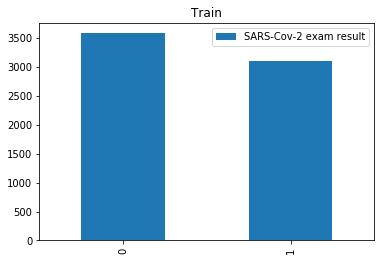

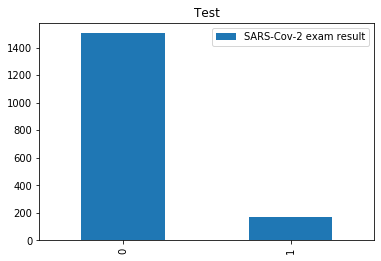

In [18]:
df_h2o = h2o.H2OFrame(df_clean)
df_h2o = df_h2o[1:,:]
train,test = df_h2o.split_frame(ratios=[.7], seed = 1)

x = train.columns
y = label_fields[0]
x.remove(y)

train = train.as_data_frame()
list_df = [train[train[y] == 1] for _ in range(7)]
list_df.append(train)
train_overS1 = pd.concat(list_df)

train = h2o.H2OFrame(train_overS1)
train = train[1:,:]

plt.title('Train')
train.as_data_frame()[y].value_counts().plot(kind='bar', legend = True)
plt.figure()
plt.title('Test')
test.as_data_frame()[y].value_counts().plot(kind='bar', legend = True)

aml_S1, leaders_S1 = predict_autoH2oTrainTest(train, test,  y, x, exclude_algos = ["DeepLearning"], max_runtime_secs=60*60, nfold=0, sort_metric='aucpr')
leaders_S1

In [19]:
aml_S1.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid__1_AutoML_20200329_133828_model_11


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,30.0,30.0,8723.0,3.0,3.0,3.0,6.0,7.0,6.966667




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.23163785388600552
RMSE: 0.4812877038591424
LogLoss: 0.655895284416587
Mean Per-Class Error: 0.33902925480113744
AUC: 0.7221030957667629
AUCPR: 0.7905832215636059
Gini: 0.4442061915335258

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4666314526585242: 


,,0,1,Error,Rate
0,0,1118.0,2107.0,0.6533,(2107.0/3225.0)
1,1,92.0,2694.0,0.033,(92.0/2786.0)
2,Total,1210.0,4801.0,0.3658,(2199.0/6011.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.466631,0.710162,65.0
1,max f2,0.454947,0.853704,73.0
2,max f0point5,0.467881,0.619158,63.0
3,max accuracy,0.467881,0.644651,63.0
4,max precision,0.570451,1.000000,0.0
5,max recall,0.401720,1.000000,81.0
6,max specificity,0.570451,1.000000,0.0
7,max absolute_mcc,0.457240,0.390218,71.0
8,max min_per_class_accuracy,0.469223,0.437829,62.0
9,max mean_per_class_accuracy,0.467881,0.660971,63.0



Gains/Lift Table: Avg response rate: 46,35 %, avg score: 46,35 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010481,0.569826,2.157574,2.157574,1.000000,0.569941,1.000000,0.569941,0.022613,0.022613,115.757358,115.757358
1,,2,0.021128,0.569490,2.157574,2.157574,1.000000,0.569645,1.000000,0.569791,0.022972,0.045585,115.757358,115.757358
2,,3,0.030777,0.569184,2.157574,2.157574,1.000000,0.569347,1.000000,0.569652,0.020818,0.066403,115.757358,115.757358
3,,4,0.040759,0.568410,2.157574,2.157574,1.000000,0.568733,1.000000,0.569427,0.021536,0.087940,115.757358,115.757358
4,,5,0.050907,0.567443,2.157574,2.157574,1.000000,0.567957,1.000000,0.569134,0.021895,0.109835,115.757358,115.757358
5,,6,0.710198,0.469223,1.170523,1.241274,0.542518,0.472345,0.575310,0.479282,0.771716,0.881551,17.052314,24.127447
6,,7,0.800366,0.459335,0.947422,1.208169,0.439114,0.466553,0.559967,0.477848,0.085427,0.966978,-5.257839,20.816945
7,,8,0.919814,0.399740,0.276458,1.087177,0.128134,0.424689,0.503889,0.470945,0.033022,1.000000,-72.354210,8.717670
8,,9,1.000000,0.363507,0.000000,1.000000,0.000000,0.378004,0.463484,0.463493,0.000000,1.000000,-100.000000,0.000000




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.2135164043465337
RMSE: 0.46207835303824146
LogLoss: 0.6196344368267329
Mean Per-Class Error: 0.44684544917257685
AUC: 0.5528143274853801
AUCPR: 0.12341327598794954
Gini: 0.10562865497076013

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4155152324405486: 


,,0,1,Error,Rate
0,0,327.0,1177.0,0.7826,(1177.0/1504.0)
1,1,19.0,152.0,0.1111,(19.0/171.0)
2,Total,346.0,1329.0,0.714,(1196.0/1675.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.415515,0.202667,48.0
1,max f2,0.405543,0.378564,69.0
2,max f0point5,0.457240,0.138698,10.0
3,max accuracy,0.511654,0.897313,0.0
4,max precision,0.505503,0.333333,2.0
5,max recall,0.377620,1.000000,156.0
6,max specificity,0.511654,0.999335,0.0
7,max absolute_mcc,0.405543,0.080675,69.0
8,max min_per_class_accuracy,0.469223,0.410904,7.0
9,max mean_per_class_accuracy,0.415515,0.553155,48.0



Gains/Lift Table: Avg response rate: 10,21 %, avg score: 45,18 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.597612,0.469223,1.125337,1.125337,0.114885,0.469421,0.114885,0.469421,0.672515,0.672515,12.533665,12.533665
1,,2,0.696716,0.466631,1.121151,1.124741,0.114458,0.466645,0.114824,0.469027,0.111111,0.783626,12.115127,12.474130
2,,3,0.733134,0.457240,1.124053,1.124707,0.114754,0.457240,0.114821,0.468441,0.040936,0.824561,12.405330,12.470713
3,,4,0.800000,0.408860,1.049499,1.118421,0.107143,0.436361,0.114179,0.465760,0.070175,0.894737,4.949875,11.842105
4,,5,0.914627,0.399740,0.357121,1.023010,0.036458,0.401453,0.104439,0.457700,0.040936,0.935673,-64.287890,2.301009
5,,6,1.000000,0.366231,0.753486,1.000000,0.076923,0.388134,0.102090,0.451761,0.064327,1.000000,-24.651372,0.000000




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-03-29 13:39:58,6.352 sec,0.0,0.498665,0.690478,0.500000,0.000000,1.000000,0.536516,0.471458,0.637597,0.500000,0.000000,1.000000,0.897910
1,,2020-03-29 13:39:58,6.387 sec,5.0,0.495429,0.684009,0.712636,0.769278,2.157574,0.378140,0.469688,0.634238,0.553864,0.132275,1.129170,0.717015
2,,2020-03-29 13:39:58,6.416 sec,10.0,0.492234,0.677651,0.709118,0.768566,2.157574,0.379970,0.467913,0.630864,0.546830,0.116632,1.124204,0.671642
3,,2020-03-29 13:39:58,6.445 sec,15.0,0.489387,0.671999,0.720706,0.788910,2.157574,0.376476,0.466444,0.628063,0.549064,0.117073,1.124214,0.718209
4,,2020-03-29 13:39:58,6.474 sec,20.0,0.486449,0.666168,0.721853,0.789001,2.157574,0.365996,0.464773,0.624859,0.551360,0.116352,1.124214,0.721791
5,,2020-03-29 13:39:58,6.504 sec,25.0,0.483910,0.661123,0.722155,0.790243,2.157574,0.365829,0.463531,0.622462,0.549564,0.116145,1.124214,0.711642
6,,2020-03-29 13:39:58,6.533 sec,30.0,0.481288,0.655895,0.722103,0.790583,2.157574,0.365829,0.462078,0.619634,0.552814,0.123413,1.125337,0.714030



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Patient age quantile,1885.245117,1.000000,0.293339
1,Leukocytes,1767.530518,0.937560,0.275023
2,Platelets,508.006195,0.269464,0.079044
3,Lymphocytes,501.820801,0.266183,0.078082
4,Hematocrit,314.440613,0.166790,0.048926
5,Neutrophils,227.009903,0.120414,0.035322
6,Red blood Cells,214.693909,0.113881,0.033406
7,Rhinovirus/Enterovirus,179.616043,0.095275,0.027948
8,Mean corpuscular hemoglobin concentrationÂ (MCHC),163.418488,0.086683,0.025427
9,Hemoglobin,155.158401,0.082301,0.024142



See the whole table with table.as_data_frame()


## Strategy 2 - Using SMOTE

In [35]:
#First its necessary do dammy in categoric fields
df_overS2 = pd.get_dummies(df_clean, dummy_na=True) #dummy_na maybe is a good strategy as we have a lot of nulls
df_overS2 = df_overS2.fillna(0)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
13:49:10.93: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms
GBM_4_AutoML_20200329_134910,0.753689,0.750937,0.544041,0.316269,0.434912,0.189149,832,0.016867
GBM_grid__1_AutoML_20200329_134910_model_7,0.753305,0.751261,0.543959,0.317697,0.435351,0.18953,944,0.031799
GBM_grid__1_AutoML_20200329_134910_model_13,0.75215,0.749169,0.545636,0.319126,0.435939,0.190042,1045,0.022128
DRF_1_AutoML_20200329_134910,0.751549,0.749383,0.551443,0.31484,0.438041,0.19188,575,0.017818
XRT_1_AutoML_20200329_134910,0.751392,0.746686,0.556152,0.327884,0.440493,0.194034,636,0.018506
GBM_1_AutoML_20200329_134910,0.750646,0.746877,0.561704,0.335027,0.441162,0.194624,394,0.009963
GBM_grid__1_AutoML_20200329_134910_model_5,0.747877,0.748833,0.551724,0.319063,0.437697,0.191579,538,0.022622
GBM_grid__1_AutoML_20200329_134910_model_8,0.74769,0.746233,0.543931,0.316206,0.435653,0.189794,236,0.011299
GBM_grid__1_AutoML_20200329_134910_model_1,0.746725,0.744188,0.54988,0.32192,0.437646,0.191534,843,0.014336
GBM_3_AutoML_20200329_134910,0.746508,0.746269,0.549483,0.319063,0.437373,0.191295,833,0.01382


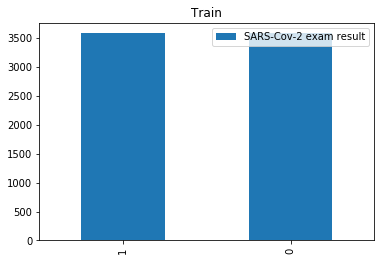

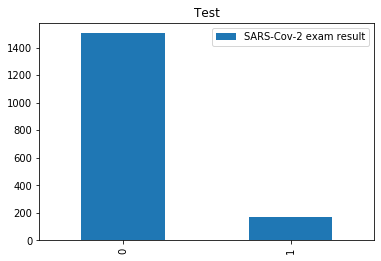

In [36]:
from imblearn.over_sampling import SMOTE
smote = SMOTE('minority')

df_h2o = h2o.H2OFrame(df_overS2)
df_h2o = df_h2o[1:,:]
train,test = df_h2o.split_frame(ratios=[.7],seed = 1)

x = train.columns
y = label_fields[0]
x.remove(y)

train = train.as_data_frame()
train = train.fillna(0)

X_sm, Y_sm = smote.fit_sample(train.drop(y, axis=1), train[y])
train = X_sm
train[y] = Y_sm
train = h2o.H2OFrame(train)
train = train[1:,:]

plt.title('Train')
train.as_data_frame()[y].value_counts().plot(kind='bar', legend = True)
plt.figure()
plt.title('Test')
test.as_data_frame()[y].value_counts().plot(kind='bar', legend = True)

aml_S2, leaders_S2 = predict_autoH2oTrainTest(train, test,  y, x, exclude_algos = ["DeepLearning"], max_runtime_secs=60*60, nfold=0, sort_metric='aucpr')
leaders_S2

In [37]:
aml_S2.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_4_AutoML_20200329_134910


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,29973.0,10.0,10.0,10.0,22.0,61.0,42.82




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.183072132860681
RMSE: 0.4278692941316086
LogLoss: 0.5241778581536584
Mean Per-Class Error: 0.31466199325156397
AUC: 0.7707654102630412
AUCPR: 0.769169856329124
Gini: 0.5415308205260825

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4744273479566797: 


,,0,1,Error,Rate
0,0,1340.0,1892.0,0.5854,(1892.0/3232.0)
1,1,153.0,3063.0,0.0476,(153.0/3216.0)
2,Total,1493.0,4955.0,0.3172,(2045.0/6448.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.474427,0.749725,183.0
1,max f2,0.317370,0.877280,196.0
2,max f0point5,0.522037,0.674455,177.0
3,max accuracy,0.511734,0.684864,179.0
4,max precision,0.990723,1.000000,0.0
5,max recall,0.046871,1.000000,309.0
6,max specificity,0.990723,1.000000,0.0
7,max absolute_mcc,0.384342,0.436579,189.0
8,max min_per_class_accuracy,0.547534,0.659035,174.0
9,max mean_per_class_accuracy,0.511734,0.685338,179.0



Gains/Lift Table: Avg response rate: 49,88 %, avg score: 49,96 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010081,0.983164,2.004975,2.004975,1.000000,0.986134,1.000000,0.986134,0.020211,0.020211,100.497512,100.497512
1,,2,0.020161,0.979417,2.004975,2.004975,1.000000,0.981319,1.000000,0.983726,0.020211,0.040423,100.497512,100.497512
2,,3,0.030087,0.974850,2.004975,2.004975,1.000000,0.977197,1.000000,0.981572,0.019900,0.060323,100.497512,100.497512
3,,4,0.040012,0.968596,2.004975,2.004975,1.000000,0.972356,1.000000,0.979286,0.019900,0.080224,100.497512,100.497512
4,,5,0.050093,0.963383,2.004975,2.004975,1.000000,0.966352,1.000000,0.976683,0.020211,0.100435,100.497512,100.497512
5,,6,0.118486,0.691877,1.695818,1.826522,0.845805,0.798070,0.910995,0.873583,0.115983,0.216418,69.581796,82.652184
6,,7,0.152140,0.650420,1.321251,1.714754,0.658986,0.650598,0.855250,0.824258,0.044465,0.260883,32.125089,71.475446
7,,8,0.219293,0.637852,1.296520,1.586681,0.646651,0.637852,0.791372,0.767176,0.087065,0.347948,29.651971,58.668116
8,,9,0.315447,0.585051,1.215920,1.473667,0.606452,0.601691,0.735005,0.716733,0.116915,0.464863,21.592040,47.366657
9,,10,0.411911,0.577775,1.173329,1.403332,0.585209,0.578625,0.699925,0.684390,0.113184,0.578047,17.332949,40.333161




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.21775487872521834
RMSE: 0.4666421313225139
LogLoss: 0.6012874241122329
Mean Per-Class Error: 0.3776420772676372
AUC: 0.6510047281323877
AUCPR: 0.21307727645399102
Gini: 0.3020094562647755

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5356828275084805: 


,,0,1,Error,Rate
0,0,843.0,661.0,0.4395,(661.0/1504.0)
1,1,54.0,117.0,0.3158,(54.0/171.0)
2,Total,897.0,778.0,0.4269,(715.0/1675.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.535683,0.246575,38.0
1,max f2,0.393468,0.408859,51.0
2,max f0point5,0.703783,0.254902,20.0
3,max accuracy,0.871990,0.903284,8.0
4,max precision,0.917282,1.000000,0.0
5,max recall,0.014033,1.000000,230.0
6,max specificity,0.917282,1.000000,0.0
7,max absolute_mcc,0.871990,0.217976,8.0
8,max min_per_class_accuracy,0.542150,0.599734,37.0
9,max mean_per_class_accuracy,0.535683,0.622358,38.0



Gains/Lift Table: Avg response rate: 10,21 %, avg score: 41,09 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010149,0.744736,6.338149,6.338149,0.647059,0.850162,0.647059,0.850162,0.064327,0.064327,533.814929,533.814929
1,,2,0.035821,0.691877,1.594587,2.938596,0.162791,0.694426,0.300000,0.738551,0.040936,0.105263,59.458724,193.859649
2,,3,0.068060,0.650420,1.088369,2.062173,0.111111,0.651782,0.210526,0.697450,0.035088,0.140351,8.836907,106.217298
3,,4,0.118806,0.637852,1.152391,1.673573,0.117647,0.637852,0.170854,0.671994,0.058480,0.198830,15.239078,67.357254
4,,5,0.165970,0.614852,1.487897,1.620809,0.151899,0.615207,0.165468,0.655856,0.070175,0.269006,48.789696,62.080862
5,,6,0.200000,0.581118,1.202934,1.549708,0.122807,0.585380,0.158209,0.643865,0.040936,0.309942,20.293424,54.970760
6,,7,0.330746,0.561039,1.476007,1.520573,0.150685,0.572235,0.155235,0.615549,0.192982,0.502924,47.600737,52.057339
7,,8,0.423284,0.542150,1.327108,1.478278,0.135484,0.545158,0.150917,0.600160,0.122807,0.625731,32.710809,47.827844
8,,9,0.519403,0.518068,0.851767,1.362338,0.086957,0.525659,0.139080,0.586373,0.081871,0.707602,-14.823290,36.233784
9,,10,0.603582,0.503015,1.111526,1.327358,0.113475,0.507058,0.135509,0.575311,0.093567,0.801170,11.152586,32.735812




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-03-29 13:49:15,0.004 sec,0.0,0.499998,0.693144,0.500000,0.000000,1.000000,0.501241,0.499013,0.691176,0.500000,0.000000,1.000000,0.897910
1,,2020-03-29 13:49:15,0.096 sec,5.0,0.463283,0.619886,0.755528,0.753584,2.004975,0.329560,0.475004,0.641938,0.638148,0.173834,5.761954,0.380299
2,,2020-03-29 13:49:15,0.189 sec,10.0,0.446944,0.583562,0.759581,0.757103,2.004975,0.326458,0.467145,0.621266,0.640123,0.174771,4.609563,0.552836
3,,2020-03-29 13:49:15,0.266 sec,15.0,0.439440,0.563800,0.762649,0.760284,2.004975,0.321805,0.465034,0.610934,0.644257,0.196575,5.761954,0.306866
4,,2020-03-29 13:49:15,0.344 sec,20.0,0.435044,0.550259,0.764533,0.761479,2.004975,0.321030,0.465581,0.606633,0.647188,0.204998,6.338149,0.332537
5,,2020-03-29 13:49:15,0.429 sec,25.0,0.432725,0.542474,0.766580,0.764844,2.004975,0.320720,0.466412,0.605133,0.650544,0.213341,6.338149,0.399403
6,,2020-03-29 13:49:15,0.506 sec,30.0,0.431143,0.536489,0.767443,0.765827,2.004975,0.319324,0.467043,0.604491,0.652754,0.205961,6.338149,0.398806
7,,2020-03-29 13:49:15,0.581 sec,35.0,0.430083,0.532365,0.768111,0.766821,2.004975,0.318393,0.466645,0.602142,0.654465,0.216160,6.338149,0.397015
8,,2020-03-29 13:49:15,0.661 sec,40.0,0.429132,0.528884,0.769584,0.768356,2.004975,0.317928,0.466253,0.600654,0.650550,0.213711,6.338149,0.397612
9,,2020-03-29 13:49:15,0.743 sec,45.0,0.428372,0.526092,0.770392,0.768947,2.004975,0.317463,0.466362,0.600518,0.650978,0.213029,6.338149,0.426866



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Patient age quantile,813.670715,1.000000,0.405135
1,Rhinovirus/Enterovirus,228.001404,0.280213,0.113524
2,Platelets,165.455139,0.203344,0.082382
3,Leukocytes,131.275589,0.161337,0.065363
4,Eosinophils,97.170067,0.119422,0.048382
5,Proteina C reativa mg/dL,68.688965,0.084419,0.034201
6,Lymphocytes,52.413292,0.064416,0.026097
7,Inf A H1N1 2009,44.521217,0.054717,0.022168
8,Mean corpuscular hemoglobin (MCH),35.296196,0.043379,0.017574
9,Influenza B,25.805370,0.031715,0.012849



See the whole table with table.as_data_frame()


## Strategy 3 - Undersampling


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
13:49:41.551: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms
GLM_1_AutoML_20200329_134941,0.601777,0.599432,0.644065,0.454545,0.478521,0.228982,4755,0.027132
GBM_grid__1_AutoML_20200329_134941_model_3,0.547137,0.558712,0.695792,0.42803,0.498567,0.248569,161,0.025965
GBM_1_AutoML_20200329_134941,0.546734,0.560922,0.794018,0.42298,0.524455,0.275053,179,0.033653
GBM_grid__1_AutoML_20200329_134941_model_13,0.540082,0.5625,0.75827,0.411616,0.516763,0.267044,173,0.03223
GBM_grid__1_AutoML_20200329_134941_model_2,0.536955,0.545455,0.687837,0.433081,0.49734,0.247347,134,0.020565
GBM_grid__1_AutoML_20200329_134941_model_1,0.536683,0.55303,0.851958,0.416667,0.529662,0.280542,334,0.026888
GBM_3_AutoML_20200329_134941,0.535003,0.57197,0.899755,0.416667,0.534009,0.285166,577,0.045376
GBM_4_AutoML_20200329_134941,0.534644,0.563763,0.878601,0.416667,0.533449,0.284568,427,0.041131
GBM_grid__1_AutoML_20200329_134941_model_5,0.532538,0.538194,0.739991,0.414141,0.512926,0.263093,195,0.02842
GBM_grid__1_AutoML_20200329_134941_model_12,0.523724,0.535354,0.67532,0.42803,0.49112,0.241199,143,0.032253


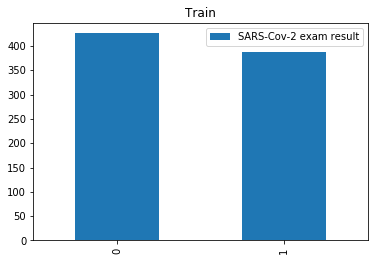

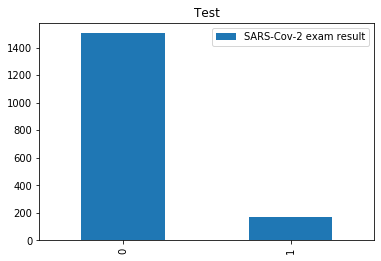

In [38]:
df_h2o = h2o.H2OFrame(df_clean)
df_h2o = df_h2o[1:,:]
train,test = df_h2o.split_frame(ratios=[.7], seed = 1)

x = train.columns
y = label_fields[0]
x.remove(y)

train = train.as_data_frame()
train_pos = train[train[y] == 1]
train_neg = train[train[y] == 0].sample(round(train_pos.shape[0]*1.1))
train = pd.concat([train_neg, train_pos])
train = h2o.H2OFrame(train)
train = train[1:,:]

plt.title('Train')
train.as_data_frame()[y].value_counts().plot(kind='bar', legend = True)
plt.figure()
plt.title('Test')
test.as_data_frame()[y].value_counts().plot(kind='bar', legend = True)

aml_S3, leaders_S3 = predict_autoH2oTrainTest(train, test,  y, x, exclude_algos = ["DeepLearning"], max_runtime_secs=60*60, nfold=0, sort_metric='aucpr')
leaders_S3

In [39]:
aml_S3.leader

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_1_AutoML_20200329_134941


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,Ridge ( lambda = 0.02081 ),"nlambda = 30, lambda.max = 8.6899, lambda.min = 0.02081, lambda.1s...",1810,1553,50,automl_training_py_360_sid_a1d7




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.21829124239619055
RMSE: 0.467216483438021
LogLoss: 0.6223750220671258
Null degrees of freedom: 732
Residual degrees of freedom: -821
Null deviance: 1014.8423251173866
Residual deviance: 912.4017823504064
AIC: 4020.4017823504064
AUC: 0.6983263972792769
AUCPR: 0.67009331520153
Gini: 0.39665279455855385

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4061837192786054: 


,,0,1,Error,Rate
0,0,136.0,246.0,0.644,(246.0/382.0)
1,1,23.0,328.0,0.0655,(23.0/351.0)
2,Total,159.0,574.0,0.367,(269.0/733.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.406184,0.709189,112.0
1,max f2,0.294939,0.837321,164.0
2,max f0point5,0.459192,0.636024,88.0
3,max accuracy,0.459192,0.652115,88.0
4,max precision,0.986236,1.000000,0.0
5,max recall,0.284534,1.000000,169.0
6,max specificity,0.986236,1.000000,0.0
7,max absolute_mcc,0.421222,0.352747,105.0
8,max min_per_class_accuracy,0.471158,0.638743,85.0
9,max mean_per_class_accuracy,0.421222,0.654447,105.0



Gains/Lift Table: Avg response rate: 47,89 %, avg score: 47,89 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010914,0.927449,2.088319,2.088319,1.000000,0.949700,1.000000,0.949700,0.022792,0.022792,108.831909,108.831909
1,,2,0.020464,0.890672,2.088319,2.088319,1.000000,0.908574,1.000000,0.930507,0.019943,0.042735,108.831909,108.831909
2,,3,0.030014,0.842410,2.088319,2.088319,1.000000,0.863519,1.000000,0.909193,0.019943,0.062678,108.831909,108.831909
3,,4,0.040928,0.773556,2.088319,2.088319,1.000000,0.808586,1.000000,0.882364,0.022792,0.085470,108.831909,108.831909
4,,5,0.050477,0.713470,1.789988,2.031878,0.857143,0.743461,0.972973,0.856085,0.017094,0.102564,78.998779,103.187803
5,,6,0.106412,0.608433,1.171496,1.579626,0.560976,0.622815,0.756410,0.733469,0.065527,0.168091,17.149607,57.962598
6,,7,0.160982,0.584093,0.939744,1.362717,0.450000,0.590542,0.652542,0.685019,0.051282,0.219373,-6.025641,36.271669
7,,8,0.204638,0.571759,1.109420,1.308680,0.531250,0.572770,0.626667,0.661072,0.048433,0.267806,10.941952,30.867996
8,,9,0.301501,0.534280,1.352995,1.322917,0.647887,0.546618,0.633484,0.624302,0.131054,0.398860,35.299547,32.291707
9,,10,0.416098,0.496409,1.168464,1.280379,0.559524,0.508984,0.613115,0.592542,0.133903,0.532764,16.846425,28.037924




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21955893973662247
RMSE: 0.4685711682728916
LogLoss: 0.6297825006724401
Null degrees of freedom: 1674
Residual degrees of freedom: 121
Null deviance: 2212.224022206397
Residual deviance: 2109.7713772526745
AIC: 5217.771377252675
AUC: 0.58890716374269
AUCPR: 0.14987353162717318
Gini: 0.17781432748538006

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4089459114140878: 


,,0,1,Error,Rate
0,0,458.0,1046.0,0.6955,(1046.0/1504.0)
1,1,21.0,150.0,0.1228,(21.0/171.0)
2,Total,479.0,1196.0,0.637,(1067.0/1675.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.408946,0.219459,172.0
1,max f2,0.397373,0.399790,187.0
2,max f0point5,0.694480,0.218182,25.0
3,max accuracy,0.952700,0.897313,0.0
4,max precision,0.704347,0.478261,22.0
5,max recall,0.156822,1.000000,377.0
6,max specificity,0.952700,0.999335,0.0
7,max absolute_mcc,0.694480,0.149076,25.0
8,max min_per_class_accuracy,0.466233,0.551197,124.0
9,max mean_per_class_accuracy,0.408946,0.590857,172.0



Gains/Lift Table: Avg response rate: 10,21 %, avg score: 45,20 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010149,0.723688,4.033368,4.033368,0.411765,0.822865,0.411765,0.822865,0.040936,0.040936,303.336773,303.336773
1,,2,0.020299,0.642751,3.457172,3.745270,0.352941,0.688511,0.382353,0.755688,0.035088,0.076023,245.717234,274.527004
2,,3,0.052537,0.608433,1.269764,2.226209,0.129630,0.610116,0.227273,0.666360,0.040936,0.116959,26.976392,122.620946
3,,4,0.118209,0.584093,0.356194,1.187312,0.036364,0.589894,0.121212,0.623879,0.023392,0.140351,-64.380649,18.731171
4,,5,0.154030,0.571759,0.979532,1.138991,0.100000,0.572414,0.116279,0.611910,0.035088,0.175439,-2.046784,13.899089
5,,6,0.200000,0.547127,1.653756,1.257310,0.168831,0.559387,0.128358,0.599838,0.076023,0.251462,65.375560,25.730994
6,,7,0.302090,0.512780,1.202934,1.238934,0.122807,0.534469,0.126482,0.577747,0.122807,0.374269,20.293424,23.893396
7,,8,0.429851,0.483773,1.098541,1.197206,0.112150,0.495951,0.122222,0.553435,0.140351,0.514620,9.854074,19.720598
8,,9,0.513433,0.458580,0.839599,1.138991,0.085714,0.463597,0.116279,0.538810,0.070175,0.584795,-16.040100,13.899089
9,,10,0.610149,0.433596,1.451159,1.188473,0.148148,0.440483,0.121331,0.523224,0.140351,0.725146,45.115876,18.847347




Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
0,,2020-03-29 13:49:41,0.000 sec,2,",87E1",1554,1.378715,1.315810
1,,2020-03-29 13:49:41,0.085 sec,4,",63E1",1554,1.376746,1.314139
2,,2020-03-29 13:49:41,0.187 sec,6,",46E1",1554,1.374190,1.311973
3,,2020-03-29 13:49:41,0.285 sec,8,",34E1",1554,1.370934,1.309221
4,,2020-03-29 13:49:42,0.386 sec,10,",24E1",1554,1.366878,1.305812
5,,2020-03-29 13:49:42,0.490 sec,12,",18E1",1554,1.361962,1.301716
6,,2020-03-29 13:49:42,0.622 sec,14,",13E1",1554,1.356197,1.296987
7,,2020-03-29 13:49:42,0.743 sec,16,",94E0",1554,1.349664,1.291770
8,,2020-03-29 13:49:42,0.854 sec,18,",68E0",1554,1.342521,1.286299
9,,2020-03-29 13:49:42,0.999 sec,20,",5E0",1554,1.334975,1.280890



See the whole table with table.as_data_frame()
